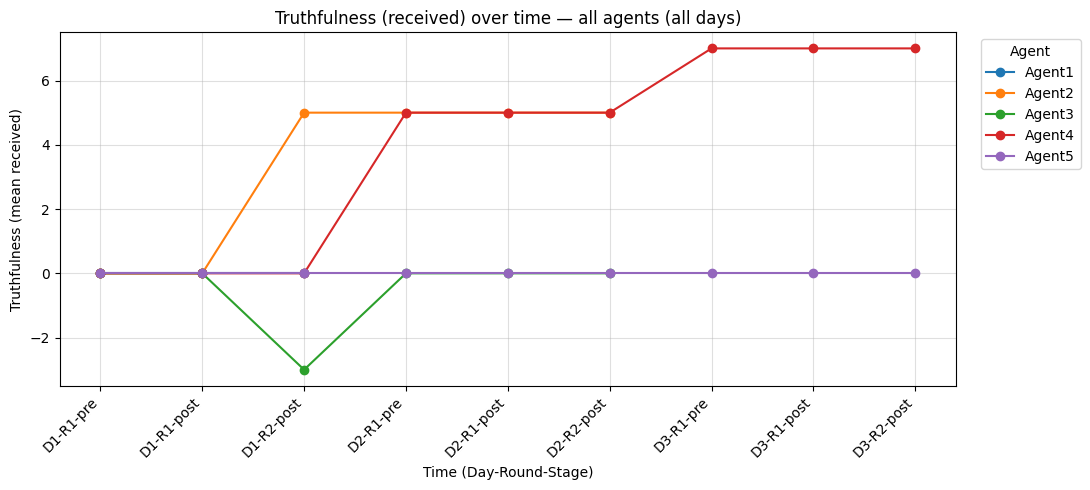

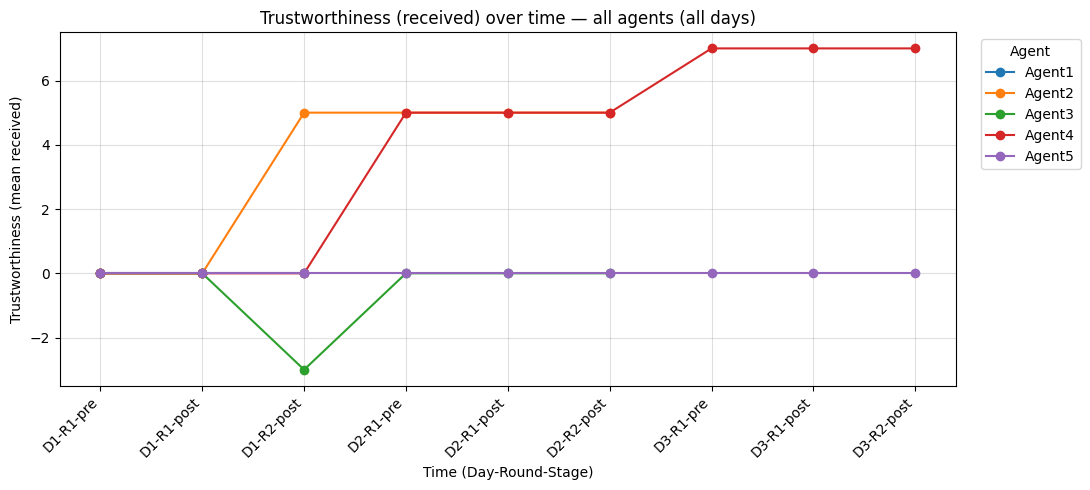

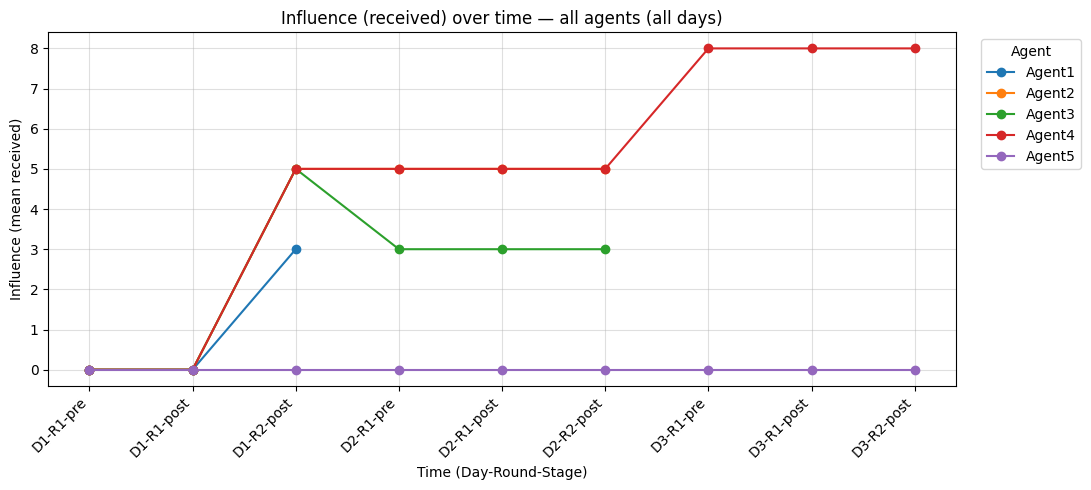

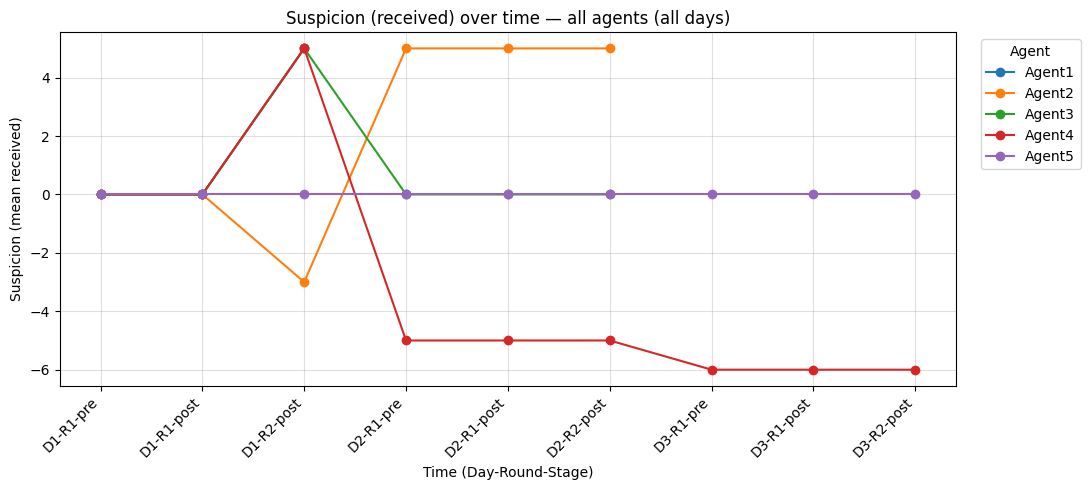

In [1]:
# ✅ Single cell: change DATA_FILE and run to plot ALL days (R1 pre, then R1 post, R2 post, ..., Rx post)

import json, re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== 1) Change this to your file path ====
DATA_FILE = "twoDiscussion_interAgentRating_7agents_2werewolves_2werewolfDiscussionRounds/game_7agents_2rounds_Manipulator_run1.json"

# ==== 2) Load & flatten events ====
def load_game(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)

def events_to_df(game_json: dict) -> pd.DataFrame:
    ev = game_json.get("events", [])
    df = pd.json_normalize(ev, sep=".")
    for col in ["phase","day","round","event_type","timestamp","stage"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

game = load_game(DATA_FILE)
events_df = events_to_df(game)

# ==== 3) Helpers ====
def safe_int(x):
    try: return int(x)
    except Exception: return np.nan

def extract_ratings_long(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Long ratings table from 'inter_agent_ratings' (per-rater) events.
    Robust to json_normalize flattening like 'ratings.AgentK.truthfulness'.
    """
    RATING_KEYS = ["truthfulness","trustworthiness","influence","suspicion"]

    def recover_ratings_mapping(row: pd.Series) -> dict:
        # Case A: ratings dict present
        if "ratings" in row.index and isinstance(row["ratings"], dict):
            return row["ratings"]
        # Case B: flattened columns
        cols = [c for c in row.index if isinstance(c,str) and c.startswith("ratings.")]
        if not cols:
            return {}
        ratees = sorted({c.split(".", 2)[1] for c in cols if len(c.split("."))>=3})
        out = {}
        for ratee in ratees:
            metrics = {}
            for k in RATING_KEYS:
                col = f"ratings.{ratee}.{k}"
                if col in row.index and pd.notna(row[col]):
                    metrics[k] = row[col]
            if metrics:
                out[ratee] = metrics
        return out

    rows = []
    sub = events_df[events_df["event_type"]=="inter_agent_ratings"].copy()
    for _, r in sub.iterrows():
        ratings_map = recover_ratings_mapping(r)
        if not ratings_map:
            continue
        rater = r.get("rater", None)
        stage = r.get("stage", None)
        day = safe_int(r.get("day", np.nan))
        rnd = safe_int(r.get("round", np.nan))
        for ratee, metrics in ratings_map.items():
            if not isinstance(metrics, dict): 
                continue
            for k in ["truthfulness","trustworthiness","influence","suspicion"]:
                val = metrics.get(k, np.nan)
                try:
                    val = float(val)
                    if np.isfinite(val):
                        val = max(-10, min(10, val))
                except Exception:
                    val = np.nan
                rows.append({
                    "day": day, "round": rnd, "stage": stage,
                    "rater": rater, "ratee": ratee,
                    "metric": k, "value": val
                })
    df = pd.DataFrame(rows)
    if df.empty:
        return pd.DataFrame(columns=["day","round","stage","rater","ratee","metric","value"])
    return df.sort_values(["day","round","stage","metric","rater","ratee"]).reset_index(drop=True)

def build_time_axis(events_df: pd.DataFrame, keep_only_r1_pre_and_all_posts=True) -> pd.DataFrame:
    """
    Build full (day, round, stage) timeline from day-phase pre/post events so every day shows on x-axis.
    If keep_only_r1_pre_and_all_posts=True -> keep R1 pre + all posts (R1 post, R2 post, ..., Rx post).
    """
    rows = []
    for _, e in events_df.iterrows():
        if e.get("phase") != "day":
            continue
        et = e.get("event_type")
        if et in ("pre_vote_round", "post_vote_round"):
            stage = "pre" if et.startswith("pre") else "post"
        elif et in ("inter_agent_ratings", "inter_agent_ratings_snapshot"):
            stage = e.get("stage")
        else:
            continue
        if stage not in ("pre","post"):
            continue
        d = safe_int(e.get("day"))
        r = safe_int(e.get("round"))
        if np.isnan(d) or np.isnan(r): 
            continue
        rows.append({"day": int(d), "round": int(r), "stage": stage})

    if not rows:
        return pd.DataFrame(columns=["day","round","stage","stage_order","t"])

    tl = pd.DataFrame(rows).drop_duplicates()
    if keep_only_r1_pre_and_all_posts:
        tl = tl[((tl["round"]==1) & (tl["stage"]=="pre")) | (tl["stage"]=="post")]

    tl["stage_order"] = tl["stage"].map({"pre":0,"post":1}).fillna(0).astype(int)
    tl = tl.sort_values(["day","round","stage_order"], kind="stable").reset_index(drop=True)
    tl["t"] = tl.apply(lambda r: f"D{r['day']}-R{r['round']}-{r['stage']}", axis=1)
    return tl

# ==== 4) Aggregate ratings (received means per time & ratee) ====
ratings_long = extract_ratings_long(events_df)

if ratings_long.empty:
    ratings_received = pd.DataFrame(columns=["day","round","stage","ratee","metric","received_mean"])
else:
    ratings_received = (
        ratings_long
        .groupby(["day","round","stage","ratee","metric"], dropna=False)["value"]
        .mean()
        .rename("received_mean")
        .reset_index()
    )

# ==== 5) Plotter using full timeline, showing ALL days ====
def plot_metric_all_agents(ratings_received: pd.DataFrame,
                           events_df: pd.DataFrame,
                           metric: str,
                           keep_only_r1_pre_and_all_posts: bool = True,
                           carry_forward: bool = False):
    """
    Plots RECEIVED <metric> (truthfulness/trustworthiness/influence/suspicion) for all agents over ALL days.
    X-axis: D#-R#-pre/post with ordering: R1-pre → R1-post → R2-post → ... (if keep_only_r1_pre_and_all_posts=True).
    Set carry_forward=True to forward-fill missing points.
    """
    timeline = build_time_axis(events_df, keep_only_r1_pre_and_all_posts).copy()
    if timeline.empty:
        print(f"No timeline found in events for plotting '{metric}'.")
        return

    df = ratings_received[ratings_received["metric"] == metric].copy()
    # Right-join to keep all timepoints (even if no ratings recorded)
    df = timeline.merge(df, on=["day","round","stage"], how="left")

    # Wide matrix: rows=time (ordered by timeline), cols=agent receiving
    wide = df.pivot_table(index="t", columns="ratee", values="received_mean", aggfunc="mean")
    wide = wide.reindex(timeline["t"])
    if carry_forward:
        wide = wide.ffill()

    # Plot
    plt.figure(figsize=(11, 5))
    cols = [c for c in (wide.columns if wide.columns is not None else []) if isinstance(c, str) and c.startswith("Agent")]
    cols = sorted(cols, key=lambda s: int(re.sub(r"[^0-9]", "", s)))
    for agent in cols:
        plt.plot(wide.index.astype(str), wide[agent], marker="o", label=agent)

    plt.title(f"{metric.capitalize()} (received) over time — all agents (all days)")
    plt.xlabel("Time (Day-Round-Stage)")
    plt.ylabel(f"{metric.capitalize()} (mean received)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.4)
    if cols:
        plt.legend(title="Agent", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ==== 6) Draw all four metrics across all days ====
for m in ["truthfulness","trustworthiness","influence","suspicion"]:
    plot_metric_all_agents(
        ratings_received, 
        events_df, 
        m, 
        keep_only_r1_pre_and_all_posts=True,   # R1-pre + all posts across all days
        carry_forward=False                     # set True if you prefer continuous lines
    )
